![UNIR](https://www.unir.net/wp-content/uploads/2014/10/logo.png)
### Máster en Inteligencia Artificial. 
**Asignatura:** _Percepción Computacional._

**Equipo 14:** Sergio Merino,  Laia Garriga, Luisa Sánchez y Miguel Á. de Frutos

**Fecha:** _29 Enero 2020_

---

# ACTIVIDAD 2: Segmentación.

**Objetivo:** Aplicar tecnicas de segmentación para aislar/detectar los patos de la imegen.
___

## 1. Importamos librerías necesarias

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2hsv
from skimage import segmentation
from skimage import color
from skimage import filters
from skimage.morphology import watershed, disk
from skimage.util import img_as_ubyte
from skimage import data
from skimage import io
from skimage.color import rgb2gray
from skimage import img_as_float
from scipy import ndimage as ndi
from skimage.segmentation import slic
from skimage import exposure
from skimage.util import invert

## 2. Importación y análisis de la imagen.

La imagen a procesar se encuentra disponible en el **Dataset FBMS-59**, un conjunto de secuencias fijas o fotogramas extraídas de diferentes videos que se desarrolló para la ***"Segmnetaciónde de objetos en movimiento"*** por las universidades de **Berkely** y posteriormnete mejoró la de **Friburgo** y que está disponible para su uso en proyectos académicos y de investigación en: https://lmb.informatik.uni-freiburg.de/resources/datasets/moseg.en.html

El DataSet no solo incorpora las imágenes (fotogramas de video), sino que también contiene por cada una de ellas un archivo de **"refrencia absoluta" o "ground-truth"** que se supone la **mejor segmentación posible** que se puede obtener de la imagen original, con el objetivo de poder analizar el rendimiento de los nuevos algorimos desarrolaldos.

Para este caso, hemos extraido la imagen **ducks01_0001.png** y su análogo "ground-truth" **ducks01_0001_gt.pgm**

Dimensiones de la imagen: (540, 960, 3)
Tipo de los elementos de la imagen: uint8


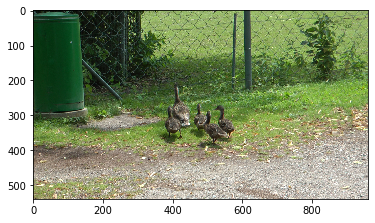

In [3]:
image=io.imread("ducks01_0001.png") # Importamos Imagen
plt.imshow(image)                   # Y Visualizamos
print("Dimensiones de la imagen: %s" % str(image.shape))
print("Tipo de los elementos de la imagen: %s" % str(image.dtype))

Hacemos una **análisis del histograma** de la imagen para observar la **distribución de color** e identificar estrategias de filtrado que facilite la segmentación.

In [ ]:
plt.hist(image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
plt.hist(image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
plt.hist(image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
plt.xlabel('Intensidad')
plt.ylabel('Amplitud')
plt.legend(['Canal_Rojo', 'Canal_verde', 'Canal_Azul'])
plt.show()

Una de las mejores estrategias para reconocer un objeto es el **cambio de color respecto al entorno**.
Se observa que al estar los patos sobre un fondo de hierba de color verde más o menos homogéneo, podemos utilizar esta clara diferenzación de color. 

Vamos a analizar como se observan los patos al **filtrar** por diferentes canales **RGB**, para intentar identificar alguna  

In [ ]:
#Solo canal Rojo
red=np.copy(image)
red[:,:,1:3]=0
plt.figure()
plt.imshow(red)

#Solo canal Verde
green=np.copy(image)
green[:,:,0]=0
plt.figure()
plt.imshow(green)

#Solo canal Azul
blue=np.copy(image)
blue[:,:,0:2]=0
plt.figure()
plt.imshow(blue)


Los patos parecen activarse más en el filtro azul-rojo, pero no aparece una diferencia clara del fondo.

Vamos a probar a convertirlo al espacio **HSV** en el que cada pixel se codifica también con tres valores:
- **Canal H**: Indica el **Tono** del color.
- **Canal S**: Indica **Saturación** del color en el pixel.
- **Canal V**: Indica la **Luminosidad** del pixel.

In [ ]:
image_hsv=color.rgb2hsv(image) # Convertir a modelo HSV

#Analizamos cada canal H-S-V por separado.
plt.figure()
plt.imshow(image_hsv[:,:,0])

plt.figure()
plt.imshow(image_hsv[:,:,1])

plt.figure()
plt.imshow(image_hsv[:,:,2])


Parece que el filtrar por el **canal H**, que contine la información del color, es el qué permite obtener una mayor diferencia de los patos y el fondo. Aprovecharemos esta ventaja, para mejorar la segmentación.

## 2. Definimos función de "Evaluación"

El enunciado proporciona una **función de evaluación** que permite introducir la imagen procesada y obtener un **factor de calidad** comparada con el mejor resultado posible, proprocionado por el "Ground-Truth o "Imagen de referencia absoluta" descargado del DataSet.

Ambas imágenes deben ser pasadas a la función transformadas a dato binario, es decir: todos los píxeles de a imagen deberán tener un valor **TRUE** (Blanco) o **FALSE** (Nebro).

Esta función devuelve un factro de calidad entre **0 y 1**. La **mejor segementación** será aquella que consiga un **factor de calidad más alto**.

In [16]:
def factor_f_evaluation(binary_image, ground_truth):
    TP = np.sum(np.logical_and(binary_image, ground_truth))
    TN = np.sum(np.logical_and(np.logical_not(binary_image), np.logical_not(ground_truth)))
    FP = np.sum(np.logical_and(np.logical_not(binary_image), ground_truth))
    FN = np.sum(np.logical_and(binary_image, np.logical_not(ground_truth)))
    P = TP/np.float(TP+FP)
    R = TP/np.float(TP+FN)
    if P+R == 0:
        F = 0
    else:
        F = 2*P*R/(P+R)
    return F

## 4. Prepocesamiento imagen de referencia "Ground-Truth".

Importamos la imagen que utilizaremos como "Ground-Truth" y analizamos su formato.

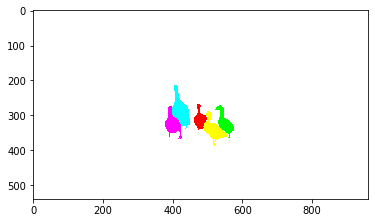

In [17]:
image_bw=io.imread('ducks01_0100_gt.png')  #Importamos
plt.imshow(image_bw)                       # Y visualizamos

Debemos definir una función que adapte el formato de nuestro "Ground-Truth" a las características de entrada que necesitamos para la función de evaluación:
- 1º: Convertimos de **RGB** a **Gray Scale**
- 2º: Convertimos la imagen a formato **decimal** con valores entre **0 y 1**.

In [18]:
def get_ground_truth(image_bw):
    ground_truth_image = img_as_float(rgb2gray(image_bw))
    return (ground_truth_image < 1)

## 5. Estrategia nº1: Segentación basada en "***Active Contour Model***"

@Sergio, si quieres puedes añadir aquí tu método...

In [19]:
def detecion_ACW(image):
    #Añadir desarrollo AQUÍ
    imagen_resultado=image
    return imagen_resultado

## 6. Estrategia nº2: Segmentación basado en color

@Luisa 
Aquí un texto que introduzca un poco la estrategia.....
.....

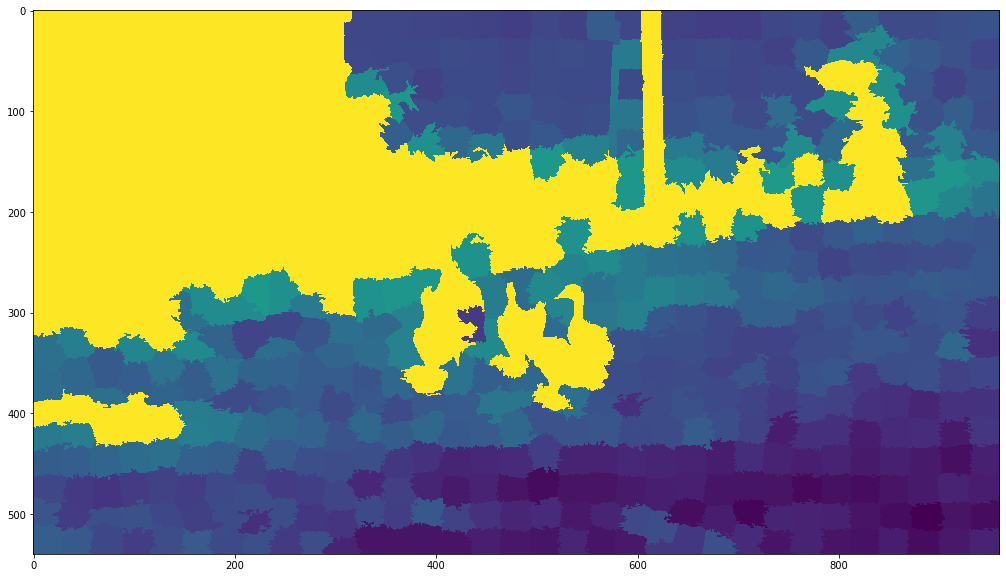

In [13]:
labels1 = slic(image, compactness=30, n_segments=600)
sliced_img = color.label2rgb(labels1, image, kind='avg')

def colorBasedSegmentation(image):
    #1. Creamos las mascaras:Verde es el color que queremos aislar
    green_rgb = np.array([[[0, 255, 0]]], dtype=np.uint8)
    light_green_rgb = np.array([[[158, 255, 158]]], dtype=np.uint8)
    green_lab = color.rgb2lab(green_rgb)
    light_green_lab = color.rgb2lab(light_green_rgb)
    light_blue_lab = color.rgb2lab([[[0, 1, 1.]]])
    blue_lab = color.rgb2lab([[[0, 0, 1.]]])
    image_lab = color.rgb2lab(image)

    # 2. Calculamos la distancia euclidea de los colores
    distance_green = color.deltaE_cmc(green_lab, image_lab, kL=0.5, kC=0.5)
    distance_light_green = color.deltaE_cmc(light_green_lab, image_lab, kL=0.5, kC=0.5)
    distance_light_blue = color.deltaE_cmc(light_blue_lab, image_lab, kL=0.5, kC=0.5)
    distance_blue = color.deltaE_cmc(blue_lab, image_lab, kL=0.5, kC=0.5)
    distance = (distance_green + distance_light_green) - (distance_light_blue +distance_blue)

    # 3. Aumentamos el contraste en relacion con la distancia entre los colores que quiero aislar y binarizamos
    distance = exposure.rescale_intensity(distance)
    image_green = image.copy()
    image_green[distance > 0.4] = 0

    image_green_gray = rgb2gray(image_green)
    
    return invert(image_green_gray, signed_float=False)


# Mostramos las imagenes
img = colorBasedSegmentation(sliced_img)
f, (ax0) = plt.subplots(1, 1, figsize=(20, 10))
ax0.imshow(img)

## 7. Estrategia nº3: Segmentación basado en "***WaterShed***"

La segmentación basada en la transformada ***WaterShed*** para el crecimiento y segmnetación de regiones se distingue frente a otras técnicas por dividir la imagen en diferentes regiones de **nivel de grises** para determinar los contornos de los elemntos que no son el fondo de la imagen.

Para ello, explota el hecho de que en los contornos el nivel de grises varía de forma abrupta. Para identificar estos pixels se utiliza el **operador gradiente**, analógo a la operación de derivación pero en superficies.

Esta transformada también es conocida como **algoritmo de inundación** por la analogía topográfica de las curas de terreno: en nuesro caso, a las coordenadas cartesianas, se le ñade una tercera coordenada que codifica el nivel de grises (altura topográfica).

El objetivo principal del algoritmo es identificar las líneas divisorias entre regiones o también conocidas como **crestas de Watershed**.

Para **evitar una sobre segmentación**, se propone una **filtrado del ruido** para suavizar diferencias entre texturas y colores además de **acotar de manera manual con una ventana** la zona de la imagen que queremos procesar.

In [21]:
def detecion_watershed(image):

    image=color.rgb2hsv(image)

    # 1: Seleccionamos el canal H(tono) de la imagen para diferenciar los patos sobre el fondo verde.
    image = image[:,:,0]

    # 2: Realizamos el filtro de Mediana para reducir el ruido de la imagen inicial.
    imagen_suavizada = filters.rank.median(image, disk(5))

    # 3: Seleccionamos las regiones continuas que tienen un gradiente inferior a 10 para quedarnos con los valles.
    #    para tener una imagen más lisa seleccionamos empíricamnete disk(3) 
    marcadores_valles = filters.rank.gradient(imagen_suavizada, disk(3)) < 10

    # 4: Procedemos a crear una mascara manual para reducir la zona de búqueda de contornos
    imagen_mascara = np.zeros_like(marcadores_valles)
    
    # 5: Manualmente  selecionamos un rectangulo alrededor de la zona donde estan los patos por medio de los pixels.
    imagen_mascara[200:350,400:570]=True
    
    # 6: Combinamos la imagen de los valles con la mascara
    marcadores_valles=marcadores_valles*imagen_mascara

    # 7: Aplicamos ndi.label para obtener las etiquetas que corresponden a cada píxel y puedan agruparse, 
    #    selecionando el parámetro [0] 
    marcadores_valles = ndi.label(marcadores_valles)[0]

    # 8: Para tener una imagen mas lisa seleccionamos disk(1), que es el mejor radio empírico.
    gradient = filters.rank.gradient(imagen_suavizada, disk(1))

    # 9: Función WATERSHED pasando como parametro el gradiente y la imagen con las marcas de los contornos 
    labels = watershed(gradient, marcadores_valles)
    imagen_resultado=(labels!=1)
    
    # 10: Devolvemos imagen segmentada
    return imagen_resultado

## 8. Ejecutamos las diferentes estratégias y comparamos rendimientos.

Evaluamos los resultados de las diferentes estrategias que se han probado:

- **Método basado en color:** Factor de evaluación **0.04**

Factor Evalucción: 0.043549172622351084


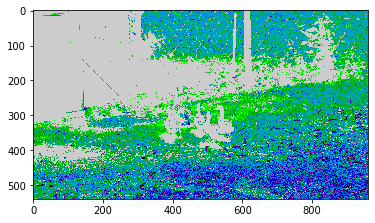

In [20]:
resultado_color = colorBasedSegmentation(image) #1: Procesmaos imagen con nuestra función 
plt.imshow(resultado_color, cmap=plt.cm.nipy_spectral, alpha=1)  # 2: Mostramos imagen segmentada.
KPI_color=factor_f_evaluation(resultado_color, get_ground_truth(image_bw)) #3: Calculamos factor calidad.
print("Factor Evalucción:",KPI_color)  #4: Mostramos QF

- **Método ACW:** Factor de evaluación **0.4**

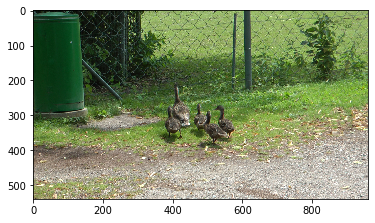

In [22]:
resultado_ACW = detecion_ACW(image) #1: Procesmaos imagen con nuestra función 
plt.imshow(resultado_ACW, cmap=plt.cm.nipy_spectral, alpha=1)  # 2: Mostramos imagen segmentada.
#KPI_ACW=factor_f_evaluation(resultado_ACW, get_ground_truth(image_bw)) #3: Calculamos factor calidad.
#print("Factor Evalucción:",KPI_ACW)  #4: Mostramos QF

- **Método WaterShed:** Factor de evaluación **0.89**

C:\Users\Usuario\Anaconda3\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Factor Evalucción: 0.8891359740560575


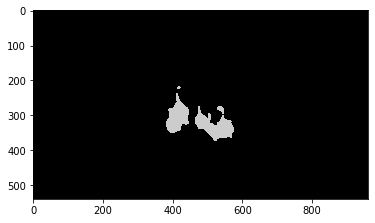

In [23]:
resultado_Watershed = detecion_watershed(image) #1: Procesmaos imagen con nuestra función 
plt.imshow(resultado_Watershed, cmap=plt.cm.nipy_spectral, alpha=1)  # 2: Mostramos imagen segmentada.
KPI_Watershed=factor_f_evaluation(resultado_Watershed, get_ground_truth(image_bw)) #3: Calculamos factor calidad.
print("Factor Evalucción:",KPI_Watershed)  #4: Mostramos QF

## 9. Análisis resultados y conclusiones.

Tras probar diferentes estrategias, el mejor resultado se ha obtenido implementando un estrategia basada en el crecimiento de regiones mediante la transformada **WaterShed** con el objetivo de determinar los contornos que definen a los patos, tras una etapa de **preprocesamiento** en la que hemos filtrado el ruido y explotado la **diferencia en color** que existe entre los patos y el fondo de verde.

Esta actividad ha superado un verdadero reto, y quebradero de cabeza, para los integrantes del equipo. 
Queda comprobado que la segmentación de imágenes, cuando no existe un claro contraste es mucho más complicada de abordar con buenos resultados de lo que podríamos imaginar de inicio.

Muchas más técncias de filtrado y estrategias que las que contiene este Notebook han sido probadas.
Aunque los resultados alcanzados no merecen ser incluidos en este informe resumen, no sería justo no hacer mención a ellos por el tiempo e entusiamos invertidos en su preparación cada miembro del equipo.

### Fin Actividad.

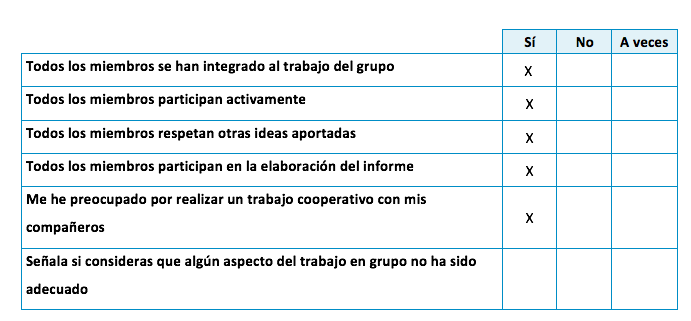